<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/cnn_50epoch_flower_D_c_G_c_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torchvision.utils as vutils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
import glob

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from torch.utils.data import DataLoader
import torchvision

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 29.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [ ]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
#ハイパーパラメータの設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=50, nch_d=64, nch_g=64, z_dim=100)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [ ]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [ ]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [ ]:
#モデルの設定

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [ ]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [ ]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [ ]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [ ]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [ ]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [ ]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [ ]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)
        
      
    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        
        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x) 


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [ ]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [ ]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=False, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [ ]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)    

        out = self.conv3(out)
      
        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [ ]:
#モデルのトレーニング

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.

In [ ]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [02:04<00:00,  1.21s/it]


epoch: 0, lossD:1.173282350169368, lossG:18.07386602938754,lossG_fake:12.629954064934, lossG_real:5.443911943837856 ,equality:7.186042121096143


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:105.10885620117188,kid_mean:0.060656070709228516, kid_std:0.015113704837858677,kid_:(tensor(0.0607), tensor(0.0151))


100%|██████████| 103/103 [00:21<00:00,  4.74it/s]


epoch: 1, lossD:0.8247881285773898, lossG:9.281848731550198,lossG_fake:5.446973421041248, lossG_real:3.834875301539319 ,equality:1.6120981195019288


evaluate:103.29491424560547,kid_mean:0.059149179607629776, kid_std:0.02452920936048031,kid_:(tensor(0.0591), tensor(0.0245))


100%|██████████| 103/103 [00:21<00:00,  4.78it/s]


epoch: 2, lossD:1.221401533889539, lossG:6.429361028578675,lossG_fake:3.6943207134320897, lossG_real:2.7350403032835247 ,equality:0.959280410148565


evaluate:105.06251525878906,kid_mean:0.051856499165296555, kid_std:0.029066186398267746,kid_:(tensor(0.0519), tensor(0.0291))


100%|██████████| 103/103 [00:21<00:00,  4.69it/s]


epoch: 3, lossD:1.0824466832343815, lossG:7.188803376503361,lossG_fake:4.197302883111157, lossG_real:2.9915004951282613 ,equality:1.2058023879828959


evaluate:122.38603210449219,kid_mean:0.0678587406873703, kid_std:0.03630644455552101,kid_:(tensor(0.0679), tensor(0.0363))


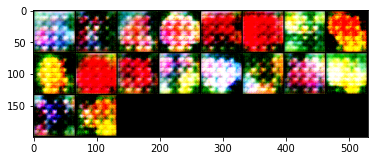

100%|██████████| 103/103 [00:23<00:00,  4.29it/s]


epoch: 4, lossD:1.0614563440813602, lossG:7.055518437357782,lossG_fake:4.132805679029631, lossG_real:2.922712752251949 ,equality:1.210092926777682


evaluate:116.62410736083984,kid_mean:0.07040562480688095, kid_std:0.03471847623586655,kid_:(tensor(0.0704), tensor(0.0347))


100%|██████████| 103/103 [00:21<00:00,  4.71it/s]


epoch: 5, lossD:1.006004618354214, lossG:7.222007654245617,lossG_fake:4.339466627361705, lossG_real:2.882541015020852 ,equality:1.4569256123408527


evaluate:115.99208068847656,kid_mean:0.0616324245929718, kid_std:0.03711812570691109,kid_:(tensor(0.0616), tensor(0.0371))


100%|██████████| 103/103 [00:22<00:00,  4.66it/s]


epoch: 6, lossD:1.0336374288913115, lossG:6.973525491732995,lossG_fake:4.242953985640146, lossG_real:2.7305715072502212 ,equality:1.5123824783899251


evaluate:114.51290893554688,kid_mean:0.0656949058175087, kid_std:0.03680681809782982,kid_:(tensor(0.0657), tensor(0.0368))


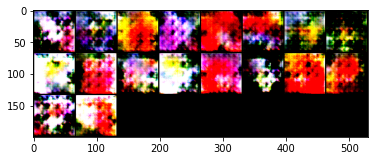

100%|██████████| 103/103 [00:21<00:00,  4.69it/s]


epoch: 7, lossD:1.0118514371728433, lossG:6.6483099067095415,lossG_fake:3.9667408674666027, lossG_real:2.681569029405279 ,equality:1.2851718380613235


evaluate:120.59671020507812,kid_mean:0.0708448588848114, kid_std:0.037853650748729706,kid_:(tensor(0.0708), tensor(0.0379))


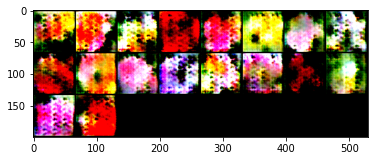

100%|██████████| 103/103 [00:22<00:00,  4.65it/s]


epoch: 8, lossD:0.9793519140447228, lossG:6.718350225281947,lossG_fake:3.9750438754998365, lossG_real:2.7433063671426865 ,equality:1.23173750835715


evaluate:118.63926696777344,kid_mean:0.06956679373979568, kid_std:0.03675195947289467,kid_:(tensor(0.0696), tensor(0.0368))


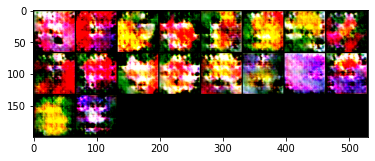

100%|██████████| 103/103 [00:23<00:00,  4.37it/s]


epoch: 9, lossD:1.0414355897787706, lossG:6.637676877882874,lossG_fake:3.96345932159609, lossG_real:2.6742175493425537 ,equality:1.2892417722535363


evaluate:113.5343246459961,kid_mean:0.060152292251586914, kid_std:0.03258815407752991,kid_:(tensor(0.0602), tensor(0.0326))


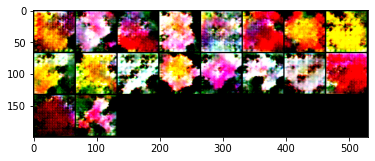

100%|██████████| 103/103 [00:21<00:00,  4.74it/s]


epoch: 10, lossD:1.1487606214088144, lossG:6.323736487083065,lossG_fake:3.7560258791284653, lossG_real:2.5677106062185415 ,equality:1.1883152729099238


evaluate:111.35771942138672,kid_mean:0.06247115135192871, kid_std:0.03438205644488335,kid_:(tensor(0.0625), tensor(0.0344))


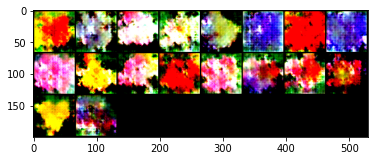

100%|██████████| 103/103 [00:21<00:00,  4.68it/s]


epoch: 11, lossD:1.061483144181446, lossG:6.199077439539641,lossG_fake:3.6403057633094416, lossG_real:2.55877169011866 ,equality:1.0815340731907814


evaluate:116.18995666503906,kid_mean:0.06339284777641296, kid_std:0.03410012647509575,kid_:(tensor(0.0634), tensor(0.0341))


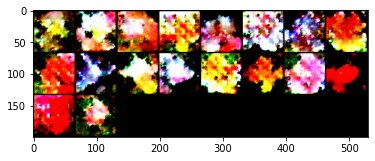

100%|██████████| 103/103 [00:22<00:00,  4.56it/s]


epoch: 12, lossD:1.0903919538826619, lossG:6.052058432866069,lossG_fake:3.5320470153706744, lossG_real:2.5200114302264836 ,equality:1.012035585144191


evaluate:110.00438690185547,kid_mean:0.0663800835609436, kid_std:0.03674355894327164,kid_:(tensor(0.0664), tensor(0.0367))


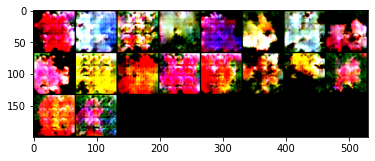

100%|██████████| 103/103 [00:24<00:00,  4.17it/s]


epoch: 13, lossD:1.0351467149928935, lossG:6.247463573529882,lossG_fake:3.6174814874686083, lossG_real:2.6299820744875566 ,equality:0.9874994129810517


evaluate:105.18856811523438,kid_mean:0.06088624894618988, kid_std:0.03260821849107742,kid_:(tensor(0.0609), tensor(0.0326))


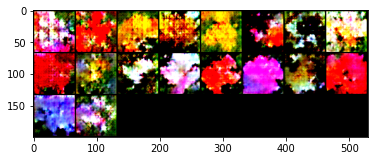

100%|██████████| 103/103 [00:22<00:00,  4.54it/s]


epoch: 14, lossD:1.06150911328862, lossG:6.083558721449768,lossG_fake:3.477692746421666, lossG_real:2.6058659541954117 ,equality:0.8718267922262544


evaluate:100.50826263427734,kid_mean:0.05654309317469597, kid_std:0.029546469449996948,kid_:(tensor(0.0565), tensor(0.0295))


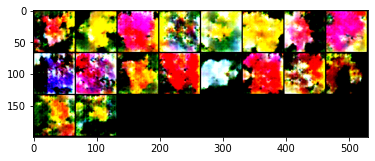

100%|██████████| 103/103 [00:22<00:00,  4.54it/s]


epoch: 15, lossD:0.9606959731544106, lossG:6.346111908699703,lossG_fake:3.6653142646678445, lossG_real:2.6807976515547742 ,equality:0.9845166131130703


evaluate:94.43582916259766,kid_mean:0.0594356544315815, kid_std:0.03443083167076111,kid_:(tensor(0.0594), tensor(0.0344))


100%|██████████| 103/103 [00:22<00:00,  4.51it/s]


epoch: 16, lossD:1.0215233104321564, lossG:6.278339987819635,lossG_fake:3.5215712334345843, lossG_real:2.7567687480195056 ,equality:0.7648024854150788


evaluate:94.21465301513672,kid_mean:0.06246263533830643, kid_std:0.03319130465388298,kid_:(tensor(0.0625), tensor(0.0332))


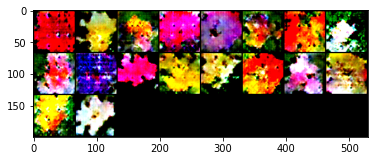

100%|██████████| 103/103 [00:24<00:00,  4.16it/s]


epoch: 17, lossD:0.9236474980428381, lossG:6.3175041189471495,lossG_fake:3.566264691862088, lossG_real:2.7512394189834595 ,equality:0.8150252728786285


evaluate:88.65705871582031,kid_mean:0.058111563324928284, kid_std:0.0360151045024395,kid_:(tensor(0.0581), tensor(0.0360))


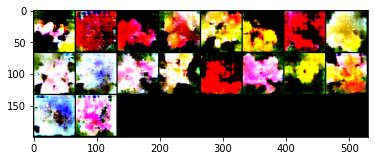

100%|██████████| 103/103 [00:28<00:00,  3.60it/s]


epoch: 18, lossD:0.9025674008050011, lossG:6.262227757463178,lossG_fake:3.4635325421407384, lossG_real:2.798695228632214 ,equality:0.6648373135085244


evaluate:90.96381378173828,kid_mean:0.058550864458084106, kid_std:0.03510648384690285,kid_:(tensor(0.0586), tensor(0.0351))


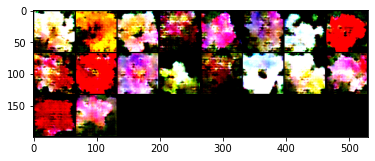

100%|██████████| 103/103 [00:24<00:00,  4.22it/s]


epoch: 19, lossD:0.8773231049185818, lossG:6.409633821654088,lossG_fake:3.5951392216589846, lossG_real:2.8144945930508736 ,equality:0.780644628608111


evaluate:90.85273742675781,kid_mean:0.05473332852125168, kid_std:0.03425412252545357,kid_:(tensor(0.0547), tensor(0.0343))


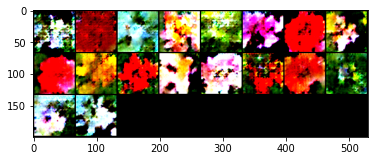

100%|██████████| 103/103 [00:23<00:00,  4.43it/s]


epoch: 20, lossD:0.8623703736992716, lossG:6.433257477954753,lossG_fake:3.5503050910616385, lossG_real:2.882952382263628 ,equality:0.6673527087980107


evaluate:90.2175064086914,kid_mean:0.06390610337257385, kid_std:0.041614655405282974,kid_:(tensor(0.0639), tensor(0.0416))


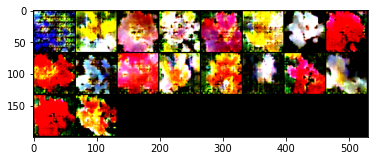

100%|██████████| 103/103 [00:24<00:00,  4.13it/s]


epoch: 21, lossD:0.8669273034461493, lossG:6.5079056684253285,lossG_fake:3.6280359238096813, lossG_real:2.8798697446156476 ,equality:0.7481661791940337


evaluate:90.5733871459961,kid_mean:0.06345989555120468, kid_std:0.0342198871076107,kid_:(tensor(0.0635), tensor(0.0342))


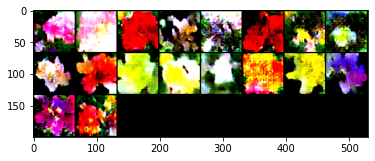

100%|██████████| 103/103 [00:22<00:00,  4.51it/s]


epoch: 22, lossD:0.8054909234486737, lossG:6.411213073915648,lossG_fake:3.5072761936095156, lossG_real:2.903936888407735 ,equality:0.6033393052017808


evaluate:90.75764465332031,kid_mean:0.06556139141321182, kid_std:0.038562435656785965,kid_:(tensor(0.0656), tensor(0.0386))


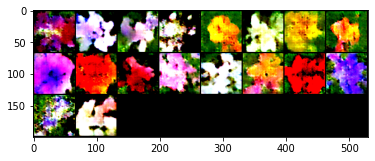

100%|██████████| 103/103 [00:22<00:00,  4.49it/s]


epoch: 23, lossD:0.7408571163716825, lossG:6.680825728814579,lossG_fake:3.7047234519014083, lossG_real:2.976102267364854 ,equality:0.7286211845365544


evaluate:90.47195434570312,kid_mean:0.06646496057510376, kid_std:0.040911074727773666,kid_:(tensor(0.0665), tensor(0.0409))


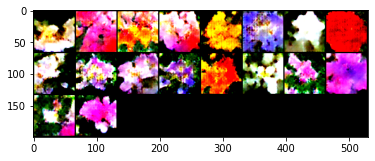

100%|██████████| 103/103 [00:22<00:00,  4.51it/s]


epoch: 24, lossD:0.7820861254212925, lossG:6.668140240085935,lossG_fake:3.6933965063789516, lossG_real:2.974743707666119 ,equality:0.7186527987128324


evaluate:90.90857696533203,kid_mean:0.0638384073972702, kid_std:0.03629854694008827,kid_:(tensor(0.0638), tensor(0.0363))


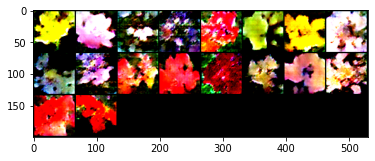

100%|██████████| 103/103 [00:24<00:00,  4.20it/s]


epoch: 25, lossD:0.7429043989881728, lossG:6.719190023477795,lossG_fake:3.6884424547547274, lossG_real:3.03074757393124 ,equality:0.6576948808234873


evaluate:92.31462860107422,kid_mean:0.06356798857450485, kid_std:0.038135454058647156,kid_:(tensor(0.0636), tensor(0.0381))


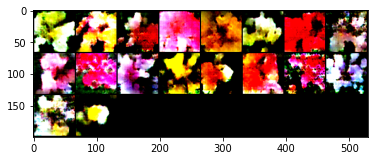

100%|██████████| 103/103 [00:22<00:00,  4.49it/s]


epoch: 26, lossD:0.7785865887276178, lossG:6.653507269701912,lossG_fake:3.69246485105996, lossG_real:2.9610424319517263 ,equality:0.7314224191082337


evaluate:92.72388458251953,kid_mean:0.07390790432691574, kid_std:0.03584448620676994,kid_:(tensor(0.0739), tensor(0.0358))


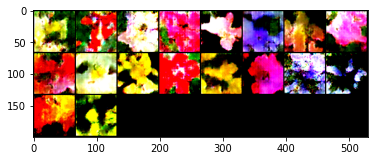

100%|██████████| 103/103 [00:22<00:00,  4.53it/s]


epoch: 27, lossD:0.7142613616961877, lossG:6.705257318552258,lossG_fake:3.623930157966984, lossG_real:3.0813271663721324 ,equality:0.5426029915948516


evaluate:94.40323638916016,kid_mean:0.06991980224847794, kid_std:0.03306114673614502,kid_:(tensor(0.0699), tensor(0.0331))


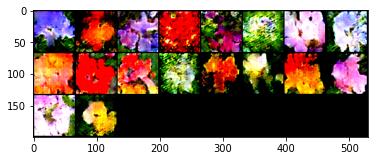

100%|██████████| 103/103 [00:22<00:00,  4.53it/s]


epoch: 28, lossD:0.6536705357935823, lossG:6.805963613454578,lossG_fake:3.7545682411749386, lossG_real:3.0513953670714664 ,equality:0.7031728741034722


evaluate:94.94674682617188,kid_mean:0.06887338310480118, kid_std:0.03359357267618179,kid_:(tensor(0.0689), tensor(0.0336))


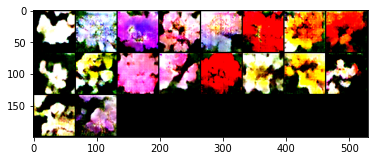

100%|██████████| 103/103 [00:24<00:00,  4.18it/s]


epoch: 29, lossD:0.6719724340635596, lossG:6.925602311069525,lossG_fake:3.832883705213232, lossG_real:3.092718604120236 ,equality:0.7401651010929959


evaluate:94.99236297607422,kid_mean:0.06757385283708572, kid_std:0.03866119682788849,kid_:(tensor(0.0676), tensor(0.0387))


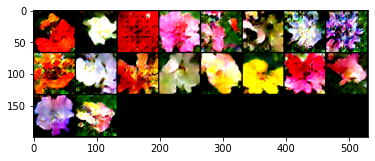

100%|██████████| 103/103 [00:22<00:00,  4.50it/s]


epoch: 30, lossD:0.7512721814287519, lossG:6.859269304182923,lossG_fake:3.781692506040184, lossG_real:3.077576808559084 ,equality:0.7041156974810998


evaluate:95.07221984863281,kid_mean:0.0668124184012413, kid_std:0.040809426456689835,kid_:(tensor(0.0668), tensor(0.0408))


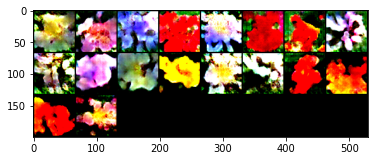

100%|██████████| 103/103 [00:23<00:00,  4.36it/s]


epoch: 31, lossD:0.6748404692388276, lossG:6.9148696927190985,lossG_fake:3.8012201346239998, lossG_real:3.1136495442066376 ,equality:0.6875705904173621


evaluate:95.50708770751953,kid_mean:0.06440410017967224, kid_std:0.04080774635076523,kid_:(tensor(0.0644), tensor(0.0408))


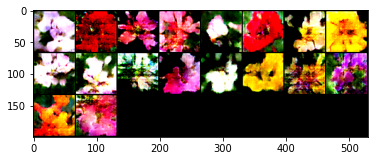

100%|██████████| 103/103 [00:23<00:00,  4.44it/s]


epoch: 32, lossD:0.6543550178842638, lossG:6.893526072641021,lossG_fake:3.710318356463053, lossG_real:3.1832077335385445 ,equality:0.5271106229245084


evaluate:97.69554901123047,kid_mean:0.06744923442602158, kid_std:0.03626645356416702,kid_:(tensor(0.0674), tensor(0.0363))


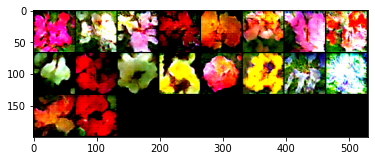

100%|██████████| 103/103 [00:24<00:00,  4.21it/s]


epoch: 33, lossD:0.6783588739853461, lossG:7.044108853756803,lossG_fake:3.8768870089817975, lossG_real:3.167221847089749 ,equality:0.7096651618920484


evaluate:98.24274444580078,kid_mean:0.07381942868232727, kid_std:0.04069947078824043,kid_:(tensor(0.0738), tensor(0.0407))


100%|██████████| 103/103 [00:22<00:00,  4.49it/s]


epoch: 34, lossD:0.6583247558005805, lossG:7.024949545999175,lossG_fake:3.8334851021905547, lossG_real:3.191464442651249 ,equality:0.6420206595393059


evaluate:98.48649597167969,kid_mean:0.07303805649280548, kid_std:0.04670034348964691,kid_:(tensor(0.0730), tensor(0.0467))


100%|██████████| 103/103 [00:23<00:00,  4.47it/s]


epoch: 35, lossD:0.6403185911114934, lossG:7.004135516083356,lossG_fake:3.8021202342024125, lossG_real:3.202015290561232 ,equality:0.6001049436411807


evaluate:100.08759307861328,kid_mean:0.07534313946962357, kid_std:0.04046756774187088,kid_:(tensor(0.0753), tensor(0.0405))


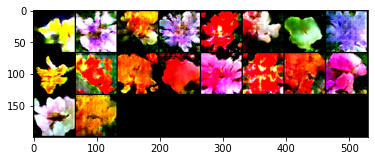

100%|██████████| 103/103 [00:22<00:00,  4.51it/s]


epoch: 36, lossD:0.6427147254637144, lossG:6.973044798212144,lossG_fake:3.7785617969568492, lossG_real:3.194482995468436 ,equality:0.5840788014884133


evaluate:100.50259399414062,kid_mean:0.07387375086545944, kid_std:0.03870897367596626,kid_:(tensor(0.0739), tensor(0.0387))


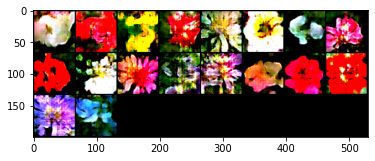

100%|██████████| 103/103 [00:22<00:00,  4.48it/s]


epoch: 37, lossD:0.6771854787196928, lossG:6.99458385208278,lossG_fake:3.7996781937126975, lossG_real:3.1949056641569413 ,equality:0.6047725295557562


evaluate:99.61073303222656,kid_mean:0.07226859778165817, kid_std:0.04395337402820587,kid_:(tensor(0.0723), tensor(0.0440))


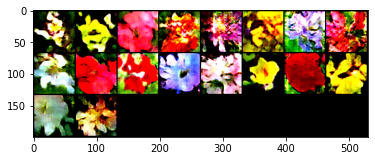

100%|██████████| 103/103 [00:23<00:00,  4.42it/s]


epoch: 38, lossD:0.6985636754232702, lossG:6.982554167219736,lossG_fake:3.7619346964706497, lossG_real:3.220619481744118 ,equality:0.5413152147265317


evaluate:100.95233154296875,kid_mean:0.06998709589242935, kid_std:0.042159948498010635,kid_:(tensor(0.0700), tensor(0.0422))


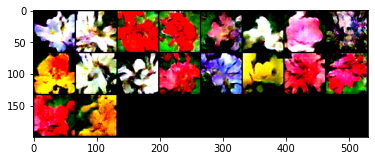

100%|██████████| 103/103 [00:23<00:00,  4.43it/s]


epoch: 39, lossD:0.6901919766537195, lossG:7.009335777134571,lossG_fake:3.766694430008675, lossG_real:3.242641356963556 ,equality:0.5240530730451192


evaluate:100.47091674804688,kid_mean:0.07631726562976837, kid_std:0.04528916999697685,kid_:(tensor(0.0763), tensor(0.0453))


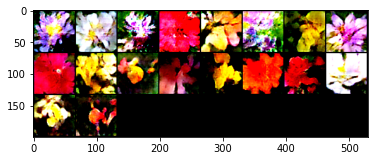

100%|██████████| 103/103 [00:24<00:00,  4.21it/s]


epoch: 40, lossD:0.6588070981421517, lossG:6.928881214660349,lossG_fake:3.764385695596343, lossG_real:3.1644955108177313 ,equality:0.5998901847786118


evaluate:101.20503997802734,kid_mean:0.07957063615322113, kid_std:0.04964626953005791,kid_:(tensor(0.0796), tensor(0.0496))


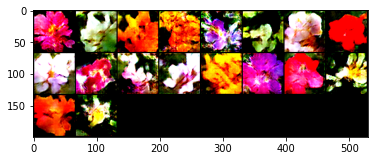

100%|██████████| 103/103 [00:23<00:00,  4.38it/s]


epoch: 41, lossD:0.632913673531662, lossG:6.917247202789899,lossG_fake:3.703096355628041, lossG_real:3.214150833852083 ,equality:0.4889455217759582


evaluate:100.7591323852539,kid_mean:0.07590170204639435, kid_std:0.04098840057849884,kid_:(tensor(0.0759), tensor(0.0410))


100%|██████████| 103/103 [00:23<00:00,  4.40it/s]


epoch: 42, lossD:0.6339087642512276, lossG:7.065276034827371,lossG_fake:3.7493539886567198, lossG_real:3.315922040383793 ,equality:0.43343194827292697


evaluate:100.72567749023438,kid_mean:0.07168527692556381, kid_std:0.04606880620121956,kid_:(tensor(0.0717), tensor(0.0461))


100%|██████████| 103/103 [00:23<00:00,  4.30it/s]


epoch: 43, lossD:0.5953714989342735, lossG:7.006309000033776,lossG_fake:3.707921767697751, lossG_real:3.2983872392802565 ,equality:0.4095345284174945


evaluate:100.34644317626953,kid_mean:0.08191024512052536, kid_std:0.0392032153904438,kid_:(tensor(0.0819), tensor(0.0392))


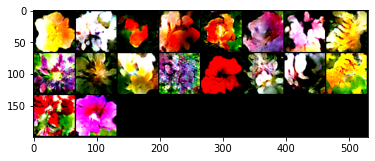

100%|██████████| 103/103 [00:23<00:00,  4.43it/s]


epoch: 44, lossD:0.6281473022496816, lossG:7.076457111580858,lossG_fake:3.8346531773076475, lossG_real:3.2418039348518963 ,equality:0.5928492424557512


evaluate:100.29828643798828,kid_mean:0.06704213470220566, kid_std:0.040286775678396225,kid_:(tensor(0.0670), tensor(0.0403))


100%|██████████| 103/103 [00:22<00:00,  4.48it/s]


epoch: 45, lossD:0.5920579698913305, lossG:7.041841363443912,lossG_fake:3.785430505437758, lossG_real:3.2564108562700955 ,equality:0.5290196491676626


evaluate:100.27943420410156,kid_mean:0.07582545280456543, kid_std:0.043995123356580734,kid_:(tensor(0.0758), tensor(0.0440))


100%|██████████| 103/103 [00:23<00:00,  4.40it/s]


epoch: 46, lossD:0.596645289543763, lossG:7.14110783697332,lossG_fake:3.825386599429603, lossG_real:3.315721224233942 ,equality:0.5096653751956608


evaluate:101.26866912841797,kid_mean:0.07604087144136429, kid_std:0.039943043142557144,kid_:(tensor(0.0760), tensor(0.0399))


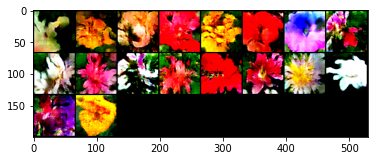

100%|██████████| 103/103 [00:23<00:00,  4.43it/s]


epoch: 47, lossD:0.5774266203340975, lossG:7.150723716587696,lossG_fake:3.7629936678895675, lossG_real:3.387730048698129 ,equality:0.37526361919143847


evaluate:100.84061431884766,kid_mean:0.07143665105104446, kid_std:0.04248495772480965,kid_:(tensor(0.0714), tensor(0.0425))


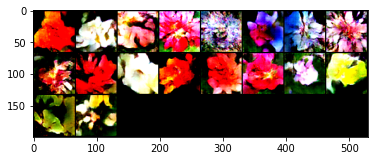

100%|██████████| 103/103 [00:23<00:00,  4.39it/s]


epoch: 48, lossD:0.6112530849222998, lossG:7.11584940697383,lossG_fake:3.7116161677443866, lossG_real:3.404233220711495 ,equality:0.3073829470328917


evaluate:99.8619155883789,kid_mean:0.07336170226335526, kid_std:0.041221845895051956,kid_:(tensor(0.0734), tensor(0.0412))


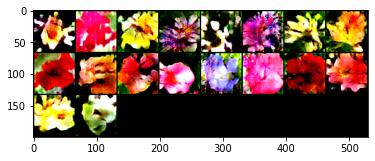

100%|██████████| 103/103 [00:23<00:00,  4.38it/s]


epoch: 49, lossD:0.5837412049758781, lossG:7.133829871427666,lossG_fake:3.766945196586905, lossG_real:3.3668846922013365 ,equality:0.4000605043855687


evaluate:99.58438110351562,kid_mean:0.06983395665884018, kid_std:0.036785464733839035,kid_:(tensor(0.0698), tensor(0.0368))


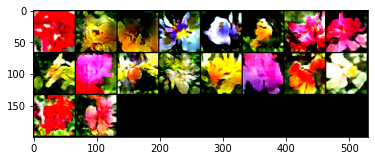

In [ ]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

In [ ]:
plt.plot(raw_lossesD)

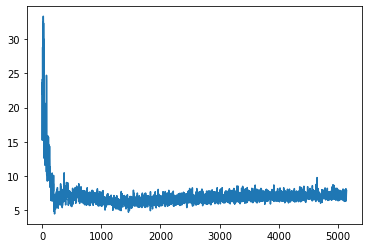

In [ ]:
plt.plot(raw_lossesG)

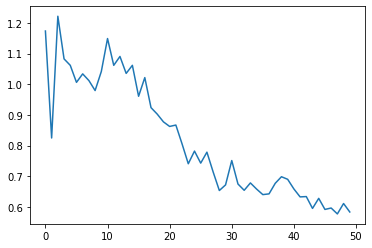

In [ ]:
plt.plot(lossesD)

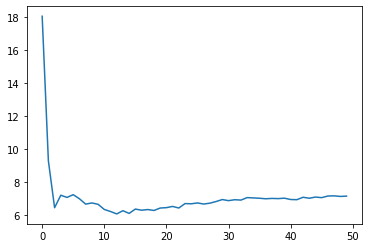

In [ ]:
plt.plot(lossesG)

In [ ]:
plt.plot(fid_)

In [ ]:
plt.plot(kid_mean_)

In [ ]:
plt.plot(kid_std_)

In [ ]:
plt.plot(kid_score)

In [ ]:
plt.plot(d_equality)

In [ ]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0730), tensor(0.0380))